In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.optimize import root, minimize, lsq_linear
from scipy.ndimage import gaussian_filter1d
from scipy.special import softmax
# import h5py 
import mat73
# import warnings
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LinearSegmentedColormap

import itertools
import os, sys
sys.path.append('../utils')
from plotting import hide_spines, set_share_axes, add_cbar 
sys.path.append('../neural_analysis')
from analysisUtils import infer_dist, expectile_loss_fn, run_decoding
from basis import create_basis
sys.path.append('../behavior_analysis')
from traceUtils import get_alphas
# from matio import loadmat

In [2]:
plt.style.use('paper_export')
reward_cmap = plt.cm.jet_r(np.linspace(0., 1., 8))
asym_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",[reward_cmap[1], reward_cmap[-1]])

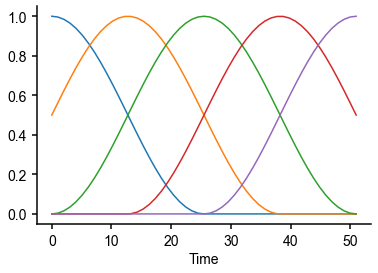

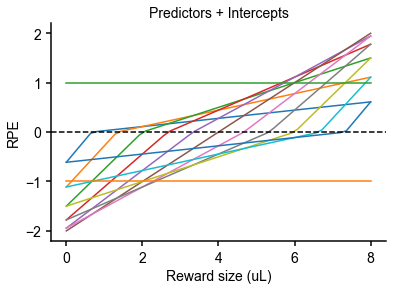

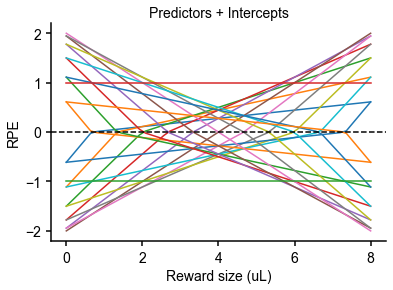

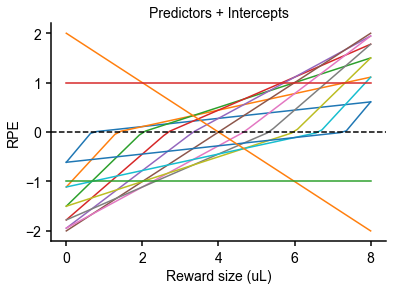

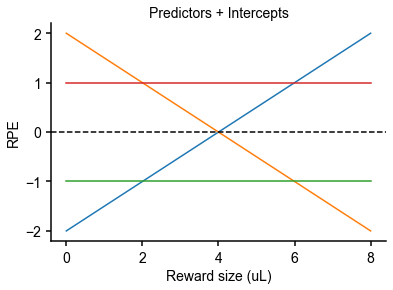

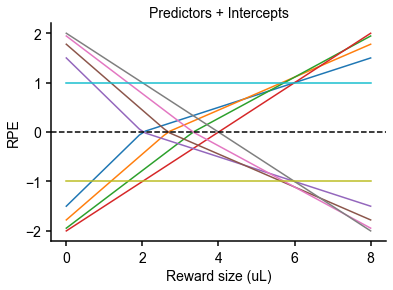

In [3]:
# the targets that we will end up trying to model
n_support = 51
n_bases = 5
n_preds = 11

bases, widths, centers = create_basis(n_support, n_bases)
# support = np.linspace(centers[0], centers[-1], 51)

taus = np.linspace(0.0, 1., n_preds+2)[1:-1]
beta = 1
alpha_pos = taus * beta
alpha_neg = (1. - taus) * beta

# distro = np.arange(0, 10, 2)
distro = np.array([0, 8])
reversals = infer_dist(taus=taus, dist=distro)

support = np.linspace(distro[0], distro[-1], n_support)
iino_data = {'d1': {'neg': 0.5, 'pos': 2},
             'd2': {'neg': 2, 'pos': 0.5}}

response = np.zeros((n_support, n_preds))
d1 = np.zeros((n_support, n_preds))
d2 = np.zeros((n_support, n_preds))

for i_amt, amt in enumerate(support):
    delta = amt - reversals
    isneg = np.array(delta < 0, dtype=np.float32)
    for i_indic, indic in enumerate(isneg):
        if indic:
            response[i_amt, i_indic] = alpha_neg[i_indic] * delta[i_indic]
            d1[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d1']['neg']
            d2[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d2']['neg']
        else:
            response[i_amt, i_indic] = alpha_pos[i_indic] * delta[i_indic]
            d1[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d1']['pos']
            d2[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d2']['pos']
        
# fit intercept, which requires explicitly giving a -1 and +1 column
response1 = np.hstack((response, -np.ones((n_support, 1)), np.ones((n_support, 1))))
response2 = np.hstack((response, -response, -np.ones((n_support, 1)), np.ones((n_support, 1))))
response3 = np.hstack((response, np.linspace(2, -2, n_support)[:, np.newaxis], 
                      -np.ones((n_support, 1)), np.ones((n_support, 1))))
response4 = np.stack((np.linspace(-2, 2, n_support), np.linspace(2, -2, n_support), 
                      -np.ones(n_support), np.ones(n_support)), axis=1)
central_response = response[:, (n_preds - 1) // 4 : 3 * ((n_preds - 1) // 4)]
response5 = np.hstack((central_response, -central_response, -np.ones((n_support, 1)), np.ones((n_support, 1))))

responses = [response1, response2, response3, response4, response5]

for this_response in responses:
    plt.figure()
    plt.plot(support, this_response)
    plt.axhline(0, c='k', ls='--')
    plt.xlabel('Reward size (uL)')
    plt.ylabel('RPE')
    plt.title('Predictors + Intercepts')
    hide_spines()

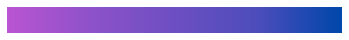

In [40]:
n_col = 6
opt_palette = {'Pessimistic': '#BA55D3', 'Optimistic': '#0047AB'}
# colors = [mcol.to_rgb(x) for x in opt_palette.values()]
# cm = LinearSegmentedColormap.from_list('', np.array(colors), 256)

def get_colors(n_colors, cmap, vmin=0, vmax=1):
    """
    For a given colormap, return a list of colors spanning that colormap.
    """
    return cmap(np.linspace(vmin, vmax, n_colors))

rgb = [mcol.to_rgb(x) for x in opt_palette.values()]
uniform = mcol.LinearSegmentedColormap.from_list('', np.array(rgb), 256)
ucols = get_colors(256, cmap=uniform)
cm = mcol.LinearSegmentedColormap.from_list('', ucols[np.array([0, 60, 105, 150, 255]), :], 256)

# x = np.linspace(0.0, 1.0, 100)
# # Get RGB values for colormap.
# rgb = cm(x)[np.newaxis, :, :3]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect=10, cmap=cm)
plt.axis('off')
plt.savefig('figs/color_gradient.pdf')

# REDRL model schematic

In [41]:
# for i_col in range(n_col // 2):
schematic_taus = np.array([.3, .5, .7])
for tau in schematic_taus:
#     c = cm(i_col / (n_col - 1))
    c = cm(tau)
    print(mcol.to_hex(c))

#8851c8
#6d4fc2
#534dbd


[0.01298701 0.02702703 0.04225352 0.05882353 0.07692308 0.09677419
 0.11864407 0.14285714 0.16981132 0.2        0.23404255 0.27272727
 0.31707317 0.36842105 0.42857143 0.5        0.5862069  0.69230769
 0.82608696 0.17391304 0.30769231 0.4137931  0.5        0.57142857
 0.63157895 0.68292683 0.72727273 0.76595745 0.8        0.83018868
 0.85714286 0.88135593 0.90322581 0.92307692 0.94117647 0.95774648
 0.97297297 0.98701299]
[0.1038961  0.21621622 0.33802817 0.47058824 0.61538462 0.77419355
 0.94915254 1.14285714 1.35849057 1.6        1.87234043 2.18181818
 2.53658537 2.94736842 3.42857143 4.         4.68965517 5.53846154
 6.60869565 1.39130435 2.46153846 3.31034483 4.         4.57142857
 5.05263158 5.46341463 5.81818182 6.12765957 6.4        6.64150943
 6.85714286 7.05084746 7.22580645 7.38461538 7.52941176 7.66197183
 7.78378378 7.8961039 ]


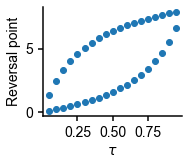

In [42]:
n_preds = 19
taus = np.linspace(.05, .95, n_preds)
redrl_alpha_avg = .015
redrl_beta = 4  # relative boost given to positive (D1) or negative (D2) RPEs
alpha_ps, alpha_ns = get_alphas(taus, redrl_alpha_avg)

alpha_ps_d1 = alpha_ps * redrl_beta
alpha_ns_d2 = alpha_ns * redrl_beta
tau_star_d1 = alpha_ps_d1 / (alpha_ps_d1 + alpha_ns)
tau_star_d2 = alpha_ps / (alpha_ps + alpha_ns_d2)
tau_star = np.concatenate((tau_star_d2, tau_star_d1))
print(tau_star)

distro = np.array([0, 8])
reversals = infer_dist(taus=tau_star, dist=distro)
print(reversals)

plt.figure(figsize=(2.5, 2))
plt.scatter(np.tile(taus, [1, 2]), reversals)
plt.xlabel(r'$\tau$')
plt.ylabel('Reversal point')
hide_spines()

In [43]:
redrl_alpha_avg = .8
iino_data = {'d1': {'neg': .75, 'pos': 3},
             'd2': {'neg': 3, 'pos': .75}}
redrl_beta = iino_data['d1']['pos'] / iino_data['d1']['neg']

alpha_ps, alpha_ns = get_alphas(schematic_taus, redrl_alpha_avg)
alpha_ps_d1 = alpha_ps * redrl_beta
alpha_ns_d2 = alpha_ns * redrl_beta
tau_star_d1 = alpha_ps_d1 / (alpha_ps_d1 + alpha_ns)
tau_star_d2 = alpha_ps / (alpha_ps + alpha_ns_d2)
tau_star = np.concatenate((tau_star_d2, tau_star_d1))
print(tau_star)

distro = np.array([0, 8])
reversals = infer_dist(taus=tau_star, dist=distro)
print(reversals)

[0.09677419 0.2        0.36842105 0.63157895 0.8        0.90322581]
[0.77419355 1.6        2.94736842 5.05263158 6.4        7.22580645]


In [44]:
# schematic_taustar = tau_star[:, np.isin(np.around(taus, 3), np.around(schematic_taus, 3)).nonzero()[0]]
# print(schematic_taustar)

# distro = np.array([0, 8])
# reversals = infer_dist(taus=schematic_taustar.flatten(), dist=distro)
# print(reversals)

In [45]:
n_support = 51
support = np.linspace(distro[0], distro[-1], n_support)
n_preds = len(reversals)

# da = np.zeros((n_support, n_preds))
# d1 = np.zeros((n_support, n_preds))
# d2 = np.zeros((n_support, n_preds))

delta = support[:, np.newaxis] - reversals[np.newaxis, :]
isneg = np.array(delta < 0)
da = delta * np.tile(alpha_ps, (1, 2))
da[isneg] = (delta * np.tile(alpha_ns, (1, 2)))[isneg]

d2 = da * iino_data['d2']['pos']
d2[isneg] = da[isneg] * iino_data['d2']['neg']

d1 = da * iino_data['d1']['pos']
d1[isneg] = da[isneg] * iino_data['d1']['neg']

# d2s are the first three predictors, d1s are the last three
msn = np.concatenate((d2[:, : n_preds // 2], d1[:, n_preds // 2 :]), axis=1)
lss = ['--'] * 3 + ['-'] * 3

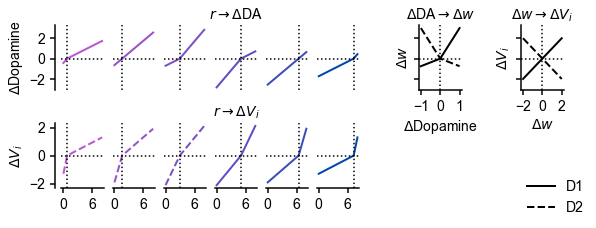

In [47]:
fig, axs = plt.subplots(2, n_col + 4, figsize=(9, 3), gridspec_kw={'hspace': .5})  #, sharey='row')
axs[0, 0].set_ylabel('$\Delta$Dopamine')
axs[1, 0].set_ylabel(r'$\Delta V_i$')

[set_share_axes(axs[:, i_col], sharex=True) for i_col in range(n_col)]
[set_share_axes(axs[i_row, :], sharey=True) for i_row in range(2)]

for i_col in range(n_col):
#     i_pred = 1 + i_col*2
    c = cm(i_col / (n_col - 1))
#     reversal = support[np.argmin(np.abs(response[:, i_pred]))]

#     c = cm(schematic_taus[i_col % len(schematic_taus)])
    
    ax = axs[0, i_col]
    ax.plot(support, da[:, i_col], c=c, lw=2)
    ax.axhline(0, c='k', ls=':')
    ax.axvline(reversals[i_col], c='k', ls=':')
    ax.spines['bottom'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([-2, 0, 2])
    
    if i_col > 0:
        ax.spines['left'].set_color('none')
        ax.set_yticks([])
    else:
        ax.spines['left'].set_position(("axes", -0.15))
    
    if i_col == (n_col) // 2:
#         ax.set_title(r'$\rightarrow$')
        ax.set_title(r'$r \rightarrow \Delta$DA')
        axs[1, i_col].set_title(r'$r \rightarrow \Delta V_i$')
    
    ax = axs[1, i_col]
    ax.plot(support, msn[:, i_col], c=c, ls=lss[i_col], lw=2)
    ax.axhline(0, c='k', ls=':')
    ax.axvline(reversals[i_col], c='k', ls=':')
    ax.set_xticks([0, 6])
    ax.set_yticks([-2, 0, 2])
    
    if i_col > 0:
        ax.spines['left'].set_color('none')
        ax.set_yticks([])
    else:
        ax.spines['left'].set_position(("axes", -0.15))

ax = axs[0, -3]
ax.plot([-1, 0, 1], [-iino_data['d1']['neg'], 0, iino_data['d1']['pos']], c='k', ls='-', lw=2)
ax.plot([-1, 0, 1], [iino_data['d2']['neg'], 0, -iino_data['d2']['pos']], c='k', ls='--', lw=2)
ax.axhline(0, c='k', ls=':')
ax.axvline(0, c='k', ls=':')
ax.set_yticks([-2, 0, 2])
ax.set_xlabel('$\Delta$Dopamine')
ax.set_ylabel(r'$\Delta w$')
ax.set_title(r'$\Delta$DA$\rightarrow \Delta w$')

ax = axs[0, -1]
ax.plot([-2, 0, 2], [-2, 0, 2], c='k', ls='-', lw=2)
ax.plot([-2, 0, 2], [2, 0, -2], c='k', ls='--', lw=2)
ax.axhline(0, c='k', ls=':')
ax.axvline(0, c='k', ls=':')
ax.set_yticks([-2, 0, 2])
ax.set_xlabel('$\Delta w$')
ax.set_ylabel('$\Delta V_i$')
ax.set_title(r'$\Delta w \rightarrow \Delta V_i$')

[ax.remove() for ax in axs[1, -4:]]
axs[0, -2].remove()
axs[0, -4].remove()
ax.legend(['D1', 'D2'], loc=(0, -2))
hide_spines()

plt.savefig('figs/d1_d2_da_expectile_model_schematic_ind.pdf')

# REDRL with smoothing

In [29]:
# Simulate REDRL from the ground up, with different degrees of smoothing in forward and reverse direction
# within (but not across) D1 and D2 MSNs

n_dists = 3
clamp_val = 6

n_preds = 20
nr_preds = n_preds // 2
taus = np.linspace(.05, .95, n_preds)
rtaus = np.linspace(.1, .9, nr_preds)
redrl_alpha_avg = .015
redrl_beta = 4  # relative boost given to positive (D1) or negative (D2) RPEs

alpha_ps, alpha_ns = get_alphas(taus, redrl_alpha_avg)
alpha_rps, alpha_rns = get_alphas(rtaus, redrl_alpha_avg)
alpha_ps_d1 = alpha_rps * redrl_beta
alpha_ns_d2 = alpha_rns * redrl_beta
tau_star_d1 = alpha_ps_d1 / (alpha_ps_d1 + alpha_rns)
tau_star_d2 = alpha_rps / (alpha_rps + alpha_ns_d2)
tau_star = np.stack((tau_star_d1, tau_star_d2), axis=0)

sigmas = [0, 3, 6, 9]
fsigmas = bsigmas = sigmas
n_forward = len(sigmas)
n_back = len(sigmas)

code_names = np.array(['EDRL', 'REDRL', 'QDRL', 'RQDRL'], dtype='object')

edrl_activity = np.zeros((n_dists, n_preds, n_forward, n_back))
qdrl_activity = np.zeros((n_dists, n_preds, n_forward, n_back))

redrl_activity = np.zeros((2, n_dists, nr_preds, n_forward, n_back))
rqdrl_activity = np.zeros((2, n_dists, nr_preds, n_forward, n_back))
rdrl_update = np.zeros((2, nr_preds))

dist_names = ['Bimodal', 'Uniform', 'Normal']
rng = np.random.default_rng(seed=1)
dists = [np.array([2, 6]), np.arange(1, 8), np.array([2, 2, 4, 4, 4, 4, 4, 4, 4, 6, 6])]  # 50% reward probability, as in Dabney et al., 2020
n_trials = 2000
distros = [rng.choice(dist, size=n_trials) for dist in dists]
# distros = [rng.choice([2, 6], size=n_trials), rng.uniform(1, 7, size=n_trials), rng.normal(4, scale=2, size=n_trials)]

for i_dist, distro in enumerate(distros):
    for i_forward, fsigma in enumerate(fsigmas):
        for i_back, bsigma in enumerate(bsigmas):
            for i_trial in range(n_trials):
                for (activity, ractivity), scale, fun in zip(
                    [(edrl_activity, redrl_activity), (qdrl_activity, rqdrl_activity)], [1, 4], [lambda x: x, np.sign]):
                    
                    # redrl/rqdrl
                    Vis = ractivity[..., i_forward, i_back].copy()
                    Vis[1] = clamp_val - ractivity[1, ..., i_forward, i_back]  # D2 -> ventral pallidum
                    
                    Vback = gaussian_filter1d(Vis, bsigma, axis=-1, mode='constant', cval=0) if bsigma > 0 else Vis
                    
                    delta = distro[i_trial] - Vback[:, i_dist, :]  # dopamine
                    isneg = np.array(delta < 0, dtype=np.float32)
                    rdrl_update[0] = fun(delta[0]) * scale * (isneg[0] * alpha_rns + (1 - isneg[0]) * alpha_ps_d1)  # compute update
                    rdrl_update[1] = -fun(delta[1]) * scale * (isneg[1] * alpha_ns_d2 + (1 - isneg[1]) * alpha_rps)
                    
                    rdrl_update = gaussian_filter1d(rdrl_update, fsigma, axis=-1, mode='constant', cval=0) if fsigma > 0 else rdrl_update
                    
                    ractivity[:, i_dist, :, i_forward, i_back] += rdrl_update  # update striatum
                    
                    # qdrl/edrl
                    Vis = activity[..., i_forward, i_back]
                    Vback = gaussian_filter1d(Vis, bsigma, axis=-1, mode='constant', cval=0) if bsigma > 0 else Vis
                    delta = distro[i_trial] - Vback[i_dist, :]  # dopamine
                    isneg = np.array(delta < 0, dtype=np.float32)
                    update = fun(delta) * scale * 2 * (isneg * alpha_ns + (1 - isneg) * alpha_ps)  # compute update
                    update = gaussian_filter1d(update, fsigma, axis=-1, mode='constant', cval=0) if fsigma > 0 else update
                    activity[i_dist, :, i_forward, i_back] += update  # update striatum

In [35]:
code_names

array(['EDRL', 'REDRL', 'QDRL', 'RQDRL'], dtype=object)

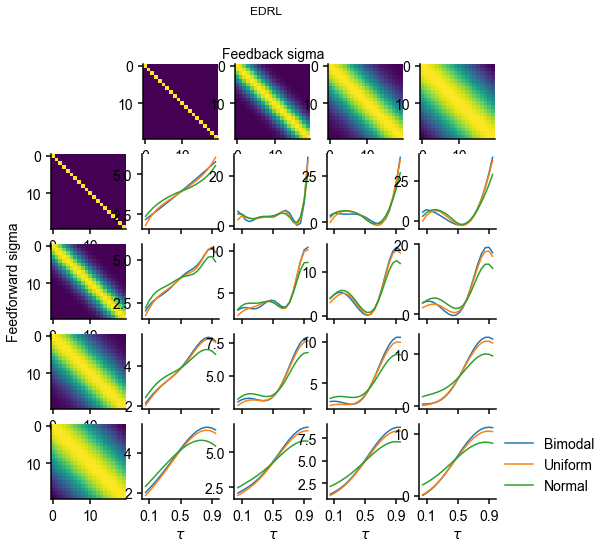

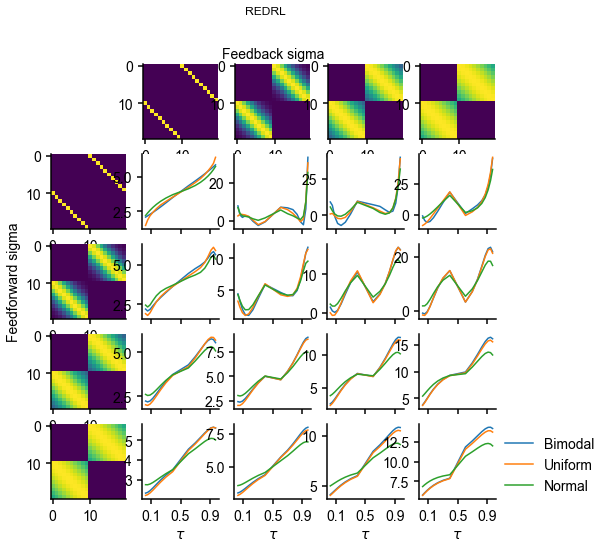

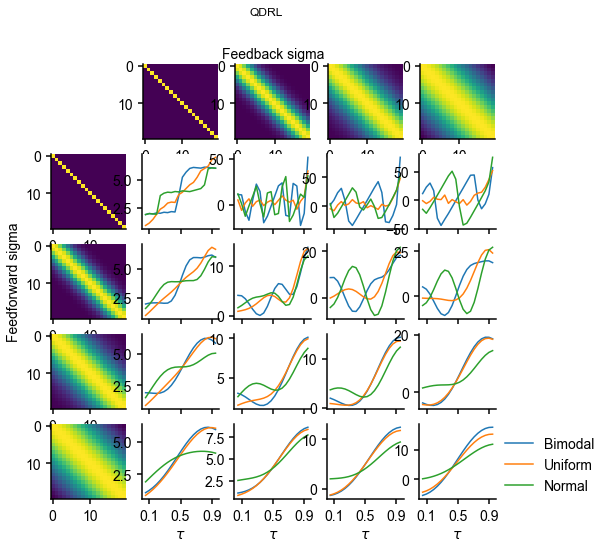

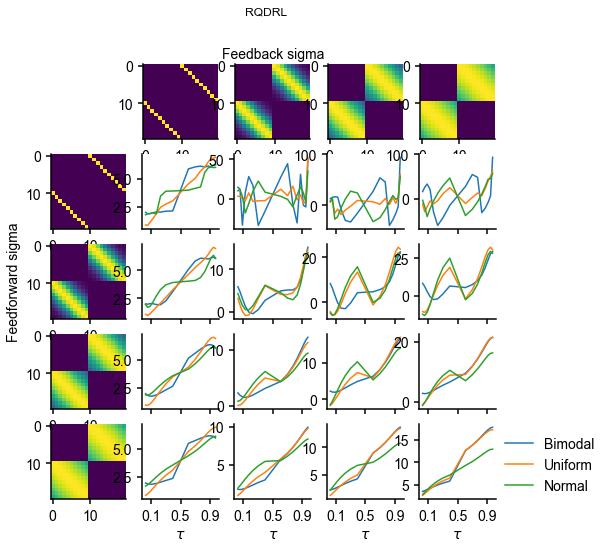

In [36]:
wassersteins = np.zeros((len(code_names), n_dists, n_forward, n_back))

for i_code, (activity, code_name) in enumerate(zip([edrl_activity, redrl_activity, qdrl_activity, rqdrl_activity],
                                               code_names)):
    
    fig, axs = plt.subplots(len(fsigmas) + 1, len(bsigmas) + 1, figsize=(8, 8))
    axs[0, 0].remove()
#     [set_share_axes(axs[i, 1:], sharey=True) for i in range(1, axs.shape[0])]
    [set_share_axes(axs[1:, i], sharex=True) for i in range(1, axs.shape[1])]
#     [set_share_axes(axs[1:, i], sharex=True) for i in range(1, axs.shape[1])]
    
    ex = np.eye(nr_preds) if code_name in ['REDRL', 'RQDRL'] else np.eye(n_preds)
    
    for i_dist, distro in enumerate(distros):
        for i_forward, fsigma in enumerate(fsigmas):
            for i_back, bsigma in enumerate(bsigmas):

                ax = axs[i_forward + 1, i_back + 1]
                ax.set_xticks([0.1, 0.5, 0.9])
                
                bsmooth = gaussian_filter1d(ex, bsigma, axis=-1, mode='constant', cval=0) if bsigma > 0 else ex
                fsmooth = gaussian_filter1d(ex, fsigma, axis=-1, mode='constant', cval=0) if fsigma > 0 else ex

                if activity is edrl_activity or activity is qdrl_activity:
                    bex = bsmooth.copy()
                    fex = fsmooth.copy()
                    tau_crop = taus
                    V_crop = activity[i_dist, :, i_forward, i_back]
#                     ax.plot(taus, activity[i_dist, :, i_forward, i_back])
#                     if activity is edrl_activity:
#                         decoded_dist, _ = run_decoding(activity[i_dist, :, i_forward, i_back], taus, minv=0, maxv=8)
#                     else:
#                         decoded_dist = activity[i_dist, :, i_forward, i_back]
                else:
                    bex = np.zeros((n_preds, n_preds))
                    fex = np.zeros((n_preds, n_preds))
                    bex[:nr_preds, nr_preds:] = bsmooth
                    bex[nr_preds:, :nr_preds] = bsmooth
                    fex[:nr_preds, nr_preds:] = fsmooth
                    fex[nr_preds:, :nr_preds] = fsmooth

    #                 ax.plot(tau_star[0], activity[0, i_dist, :, i_forward, i_back], color='#FFA001')
    #                 ax.plot(tau_star[1], activity[1, i_dist, :, i_forward, i_back], color='#0A704E')

                    Vis = activity.copy()
                    Vis[1, :, :] = clamp_val - activity[1, :, :]  # D2 -> ventral pallidum
                    
                    tau_crop = np.concatenate((tau_star[1, tau_star[1] < .5], tau_star[0, tau_star[0] > .5]))
                    V_crop = np.concatenate((Vis[1, i_dist, tau_star[1] < .5, i_forward, i_back],
                                            Vis[0, i_dist, tau_star[0] > .5, i_forward, i_back]))
                    
#                     tau_sort = np.argsort(tau_star.flatten())
#                     ax.plot(tau_star.flatten()[tau_sort], Vis[:, i_dist, :, i_forward, i_back].flatten()[tau_sort])
#                     if activity is redrl_activity:
#                         decoded_dist, _ = run_decoding(V_crop, tau_crop, minv=0, maxv=8)
# #                         decoded_dist, _ = run_decoding(Vis[:, i_dist, :, i_forward, i_back].flatten(),
# #                                                        tau_star.flatten(), minv=2., maxv=6.)
#                     else:
#                         decoded_dist = Vis[:, i_dist, :, i_forward, i_back]
                ax.plot(tau_crop, V_crop)
    
#                 if not(i_back > 1 and i_forward < 1):
#                     ax.plot(tau_crop, V_crop)
#                 else:
#                     try: ax.remove()
#                     except ValueError: pass  # already removed
                    
                if activity is edrl_activity or activity is redrl_activity:
                    decoded_dist, _ = run_decoding(V_crop, tau_crop, minv=0, maxv=8)
#                         decoded_dist, _ = run_decoding(Vis[:, i_dist, :, i_forward, i_back].flatten(),
#                                                        tau_star.flatten(), minv=2., maxv=6.)
                else:
                    decoded_dist = V_crop
                        
                if i_forward == 0:
#                     smooth = gaussian_filter1d(ex, bsigma, axis=-1, mode='constant', cval=0) if bsigma > 0 else ex
                    axs[i_forward, i_back + 1].imshow(bex)
                elif i_forward == n_forward - 1:
                    axs[i_forward + 1, i_back + 1].set_xlabel(r'$\tau$')
                if i_back == 0:
#                     smooth = gaussian_filter1d(ex, fsigma, axis=-1, mode='constant', cval=0) if fsigma > 0 else ex
                    axs[i_forward + 1, i_back].imshow(fex)
                
                wassersteins[i_code, i_dist, i_forward, i_back] = stats.wasserstein_distance(distro, decoded_dist)
    
    axs[len(fsigmas) // 2, 0].set_ylabel('Feedforward sigma')
    axs[0, len(bsigmas) // 2].set_title('Feedback sigma')
    axs[-1, -1].legend(loc=(1.04, 0), labels=dist_names)
    fig.suptitle(code_name)
#     fig.tight_layout(rect=[0, .03, 1, 0.95])
    
    hide_spines()
    plt.savefig(f'figs/{code_name}_matrix.pdf')
    

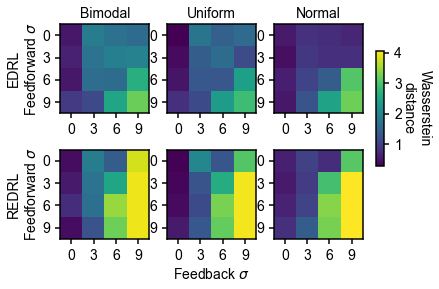

In [37]:
code_inds = np.array([0, 1])
use_w = wassersteins[code_inds]
fig, axs = plt.subplots(len(code_inds), n_dists)
axs[-1, n_dists // 2].set_xlabel('Feedback $\sigma$')
for i_code, code_name in enumerate(code_names[code_inds]):
    for i_dist, dist_name in enumerate(dist_names):
        ax = axs[i_code, i_dist]
        im = ax.imshow(use_w[i_code, i_dist], vmin=np.amin(use_w), vmax=np.amax(use_w))
        ax.set_yticks(np.arange(len(fsigmas)))
        ax.set_yticklabels(fsigmas)
        ax.set_xticks(np.arange(len(bsigmas)))
        ax.set_xticklabels(bsigmas)
        if i_code == 0:
            ax.set_title(dist_name)            
        if i_dist == 0:
            ax.set_ylabel(code_name + '\nFeedforward $\sigma$')
add_cbar(fig, im, 'Wasserstein\ndistance', pad=30, width=.02)
plt.savefig('figs/wass_summ.pdf')

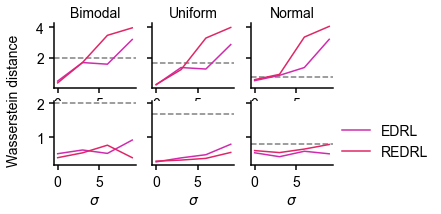

In [39]:
fig, axs = plt.subplots(2, n_dists, figsize=(5, 2.6), sharey='row')
axs[0, 0].set_ylabel('Wasserstein distance', y=-0.2, labelpad=15)
model_palette = sns.husl_palette(10, l=.5, h=.9)
for i_dist, (dist_name, distro) in enumerate(zip(dist_names, distros)):
    axs[1, i_dist].set_xlabel('$\sigma$')
    axs[0, i_dist].set_title(dist_name)
    for ax in axs[:, i_dist]:
        delta_wass = stats.wasserstein_distance(distro, [np.mean(distro)])
        ax.axhline(delta_wass, ls='--', color=[.5,.5,.5])
    for i_code, code_name in enumerate(code_names):
        if 'QDRL' not in code_name:
            axs[0, i_dist].plot(sigmas, np.diag(wassersteins[i_code, i_dist]), label=code_name, color=model_palette[i_code])
            axs[1, i_dist].plot(sigmas, wassersteins[i_code, i_dist, :, 0], label=code_name, color=model_palette[i_code])
plt.legend(loc=(1.04, 0))
hide_spines()
plt.savefig('figs/wass_quant.pdf')
# plt.tight_layout()

## Old stuff

/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[25 13 19 17 26  6 21 27]


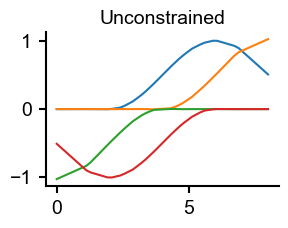

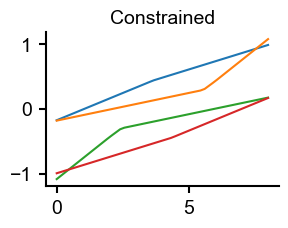

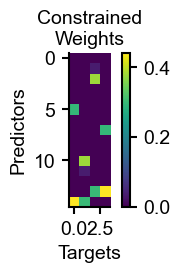

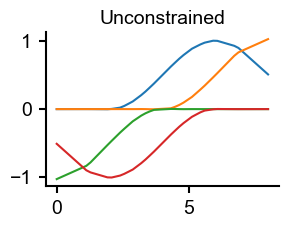

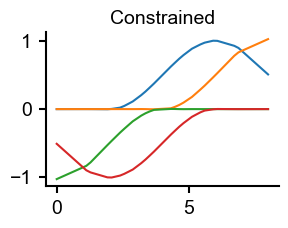

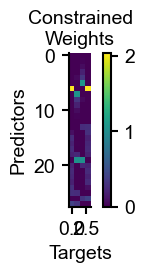

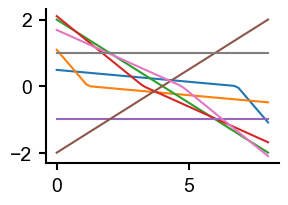

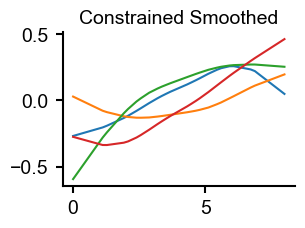

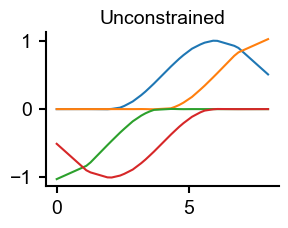

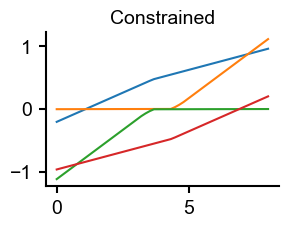

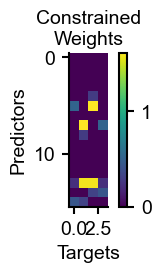

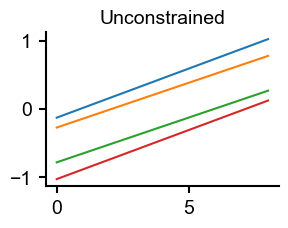

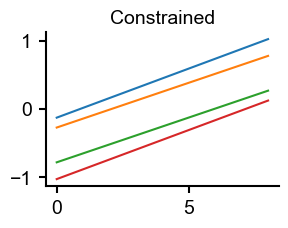

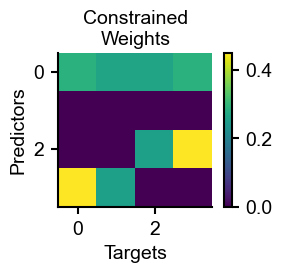

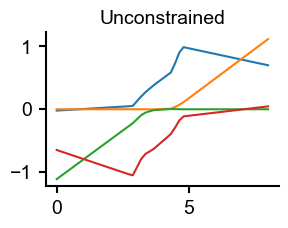

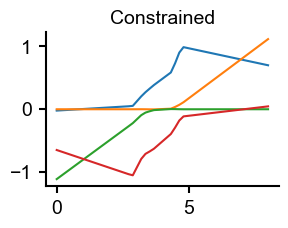

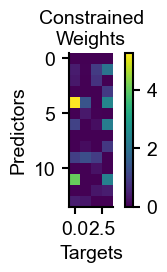

In [180]:
# now take those responses and we if we can do something interesting with them...
targets1 = np.concatenate((bases, -bases), axis=1)
targets1 = targets1[:, (n_bases - 1) // 2 + 1 : -((n_bases - 1) // 2 + 1)]
targets2 = np.zeros((n_support, n_bases))
length = int((n_support - 1) / n_bases)
for i_basis in range(n_bases):
    targets2[i_basis * length : (i_basis + 1) * length + 1, i_basis] = 1
# target_list = [targets1, targets2]
target_list = [targets1]

for targets in target_list: 

    n_targets = targets.shape[1]

    for response in responses:

        reg = LinearRegression(fit_intercept=False).fit(response, targets)
        pred = reg.predict(response)
        plt.figure()
        plt.plot(support, pred)
        plt.title('Unconstrained')

        coefs = np.zeros((response.shape[1], n_targets))
        recons = np.zeros((n_support, n_targets))

        for i_target, target in enumerate(targets.T):
            res = lsq_linear(response, target, bounds=(0, np.inf), method='bvls')
            coefs[:, i_target] = res['x']
            recons[:, i_target] = response @ res['x'] 

        plt.figure()
        plt.plot(support, recons)
        plt.title('Constrained')

        plt.figure()
        plt.imshow(coefs)
        plt.colorbar()
        plt.title('Constrained\nWeights')
        plt.ylabel('Predictors')
        plt.xlabel('Targets')

        # plot predictors with the largest weights:
        if np.all(response == response2):
            plt.figure()
            top = 8  # get indices of top 6 weights
            topinds = coefs.argsort(axis=0)[-top:, :]
            counts = np.bincount(topinds.flatten())
            idx = counts.argsort()[-top:]
            print(idx)
            plt.plot(support, response[:, idx])
            
            # see how sensitive it is to convolution
            conv_coefs = ___
            for i_target, target in enumerate(targets.T):
                res = lsq_linear(response, target, bounds=(0, np.inf), method='bvls')
                smooth_coefs = gaussian_filter1d(res['x'], 3, axis=0)
                recons[:, i_target] = response @ smooth_coefs
            plt.figure()
            plt.plot(support, recons)
            plt.title('Constrained Smoothed')


hide_spines()
    # plt.imshow(reg.coef_)

In [4]:
# def expectile_loss_fn(expectiles, taus, samples):
#     """Expectile loss function, corresponds to distributional TD model """
#     # distributional TD model: delta_t = (r + \gamma V*) - V_i
#     # expectile loss: delta = sample - expectile
#     delta = (samples[None, :] - expectiles[:, None])

#     # distributional TD model: alpha^+ delta if delta > 0, alpha^- delta otherwise
#     # expectile loss: |taus - I_{delta <= 0}| * delta^2

#     # Note: When used to decode we take the gradient of this loss,
#     # and then evaluate the mean-squared gradient. That is because *samples* must
#     # trade-off errors with all expectiles to zero out the gradient of the 
#     # expectile loss.
#     indic = np.array(delta <= 0., dtype=np.float32)
#     grad = -0.5 * np.abs(taus[:, None] - indic) * delta
#     return np.mean(np.square(np.mean(grad, axis=-1)))


# def run_decoding(reversal_points, taus, minv=0., maxv=1., method=None,
#                  max_samples=1000, max_epochs=10, N=100):
#     """Run decoding given reversal points and asymmetries (taus)."""

#     ind = list(np.argsort(reversal_points))
#     points = reversal_points[ind]
#     tau = taus[ind]

#     # Robustified optimization to infer distribution
#     # Generate max_epochs sets of samples,
#     # each starting the optimization at the best of max_samples initial points.
#     sampled_dist = []
#     for _ in range(max_epochs):
#         # Randomly search for good initial conditions
#         # This significantly improves the minima found
#         samples = np.random.uniform(minv, maxv, size=(max_samples, N))
#         fvalues = np.array([expectile_loss_fn(points, tau, x0) for x0 in samples])

#     # Perform loss minimizing on expectile loss (w.r.t samples)
#     x0 = np.array(sorted(samples[fvalues.argmin()]))
#     fn_to_minimize = lambda x: expectile_loss_fn(points, tau, x)
#     result = minimize(
#         fn_to_minimize, method=method,
#         bounds=[(minv, maxv) for _ in x0], x0=x0)['x']

#     sampled_dist.extend(result.tolist())

#     return sampled_dist, expectile_loss_fn(points, tau, np.array(sampled_dist))

def get_microstimuli(dur, n_bases=8, sigma=.1, gamma=.9):
    y_t = gamma ** np.arange(dur)
    bases = np.array([gaussian(y_t, i/n_bases, sigma) * y_t for i in range(n_bases, 0, -1)]).T  # n_timepoints x n_bases
#     plt.figure()
#     plt.plot(np.arange(dur), bases)
    return bases

def get_qda(g, phi, i_state, qs, taus, beta):
    q_delta = g - (phi[np.newaxis, i_state, :] @ qs).T  # shape (n_preds, n_preds)
    q_isneg = np.array(q_delta < 0, dtype=np.float32)  # shape (n_preds, n_preds)
    q_update = (taus[:, np.newaxis] - q_isneg)  # shape (n_preds, n_preds)  #  * phi[i_state, :, np.newaxis, np.newaxis]  # shape (n_features, n_preds, n_preds)
    return beta * np.mean(q_update, axis=1)  # shape(n_preds,) # axis = 2  # shape (n_features, n_preds)

def get_xda(g, phi, i_state, xs, taus, beta, rescale_x):
    x_delta = g - (phi[np.newaxis, i_state, :] @ xs).T  # shape (n_preds, n_preds), where dim = 1 contains different samples
    x_isneg = np.array(x_delta < 0, dtype=np.float32)  # shape (n_preds, n_preds)
    x_update = np.abs(taus[:, np.newaxis] - x_isneg) * x_delta  # [np.newaxis, :, :]  # * phi[i_state, :, np.newaxis, np.newaxis]  # shape (n_features, n_preds, n_preds)
    return beta * rescale_x * np.mean(x_update, axis=1)  # axis = 2

def get_cda(zetas, phi, i_state, ws, alpha):
    p = softmax(phi[np.newaxis, i_state, :] @ ws)  # shape (1, n_preds)
    p_prime = softmax(phi[np.newaxis, next_state, :] @ ws) # shape (1, n_preds)
    p_bar = np.sum(zetas * p_prime, axis=1)
#         print(p_bar)
    return alpha * (p_bar - p)  #  * phi[i_state, :, np.newaxis]

def gaussian(y, mu, sigma):
    return (1/np.sqrt(2*np.pi)) * np.exp(-((y - mu)**2)/(2 * sigma**2))

# Model

In [5]:
"""
0: Nothing Cue
1-2: Delay (Nothing)
3: Fixed Cue
4-5: Delay (Fixed)
6: Variable Cue
7-8: Delay (Variable)
9-11: PostRew + Foreperiod (minimum 3 seconds between reward and next cue)
12: ITI
"""

n_preds = 31
n_trials = 10000
beta = 1
gamma = .9

n_tts = 4
n_cues = 3
iti_mean = 2
dists = [np.array([0]),
         np.array([4]),
         np.array([2, 6]),
         np.array([4])]

n_trials_per_type = np.array([80, 80, 140, 20])
prior_probs = n_trials_per_type / np.sum(n_trials_per_type)

cue_dur = 3
n_cue_states = n_cues * cue_dur
n_noncue_states = 4  # Foreperiod, PostRew x 2, and ITI (one state with transition prob < 1)
n_states = n_cue_states + n_noncue_states
iti_state = n_states - 1

n_bases = 8
n_features = n_bases * n_cues + n_noncue_states

cue_bases = get_microstimuli(cue_dur, n_bases, sigma=.2, gamma=.65)
phi = np.zeros((n_states, n_features))

for i_cue in range(n_cues):
    phi[i_cue * cue_dur : (i_cue + 1) * cue_dur, i_cue * n_bases : (i_cue + 1) * n_bases] = cue_bases
phi[n_cues * cue_dur:, n_cues * n_bases:] = np.eye(n_noncue_states)

rng = np.random.default_rng(seed=1)
tt_order = rng.choice(np.arange(n_tts), n_trials, p=prior_probs)
start_states = np.array([0, 3, 6, 9])
cue_states = start_states[:-1]
cue_names = ['Nothing', 'Fixed', 'Variable']
start_rews = np.array([0, 0, 0, 4])
start_state_order = start_states[tt_order]
start_rew_order = start_rews[tt_order]
last_cue_states = start_states[:-1] + 2

outcomes = np.zeros(n_trials, dtype=np.float32)
for i_cue in range(n_cues):
    outcomes[start_state_order == i_cue * 3] = rng.choice(dists[i_cue], size=np.sum(start_state_order == i_cue * 3))

history = np.full((n_trials, n_tts), np.nan)
horizon = 5

qs = np.zeros((n_features, n_preds))
xs = np.zeros((n_features, n_preds))

taus = np.linspace(0.0, 1., n_preds+2)[1:-1]
# alpha_pos = taus * beta
# alpha_neg = (1. - taus) * beta

rescale_x = 0.15

max_pred = 12
theta = np.linspace(-1, max_pred, n_preds)
ws = np.ones((n_features, n_preds)) / n_preds
alpha = 5

hs = [[]] * n_preds
hs[1:-1] = itertools.repeat(lambda z: np.amax(np.vstack((np.zeros(len(z)), 1-np.abs(z))), axis=0), n_preds-2)
hs[0] = lambda z: np.array(z <= 0, dtype=np.float32) + np.amax(np.vstack((np.zeros(len(z)), 1-np.abs(z))), axis=0) * np.array(z > 0, dtype=np.float32)
hs[-1] = lambda z: np.array(z > 0, dtype=np.float32) + np.amax(np.vstack((np.zeros(len(z)), 1-np.abs(z))), axis=0) * np.array(z <= 0, dtype=np.float32)


supports = {}
zetas = {}
for r in range(0, 8, 2):
    print(r)
    supports[r] = (r + gamma * theta[np.newaxis, :] - theta[:, np.newaxis]) / np.mean(np.diff(theta))
    zetas[r] = np.array([hs[i_pred](supports[r][i_pred]) for i_pred in range(n_preds)])  # shape (n_preds, n_preds)

n_combos = 5
buffer_size = 100
last_da = np.zeros((3, n_combos, n_states, n_preds, buffer_size))  # 3 is ctd, qtd, and xtd

0
2
4
6


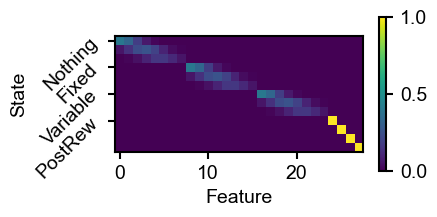

In [6]:
plt.figure(figsize=(4,2))
plt.imshow(phi)
plt.ylabel('State')
plt.xlabel('Feature')
plt.yticks(start_states, [*cue_names, 'PostRew'], rotation=45)
plt.colorbar()

In [7]:
buffer_count = np.zeros(n_combos, dtype=np.int8)

for i_trial in np.arange(n_trials - 1):
    
    i_state = start_state_order[i_trial]
    new_trial = False
    i_combo = i_state // n_cues
    if outcomes[i_trial] == 6 or i_combo == 3: i_combo += 1

    while new_trial == False:
        
        # observe next state transition and whether to begin a new trial
        if i_state in last_cue_states:
            next_state = n_cue_states
            outcome = outcomes[i_trial]
        elif i_state == iti_state:
            if rng.random() < 1 / iti_mean:
                next_state = start_state_order[i_trial + 1]
                outcome = start_rew_order[i_trial + 1]
                new_trial = True
            else:
                next_state = i_state
                outcome = 0
        else:
            next_state = i_state + 1
            outcome = 0
                    
        # compute bootstrapped return, getting samples of the next-state return distribution from the quantile weights
        g = outcome + gamma * phi[np.newaxis, next_state, :] @ qs  # shape (1, n_preds)
        
        for i_da, (da, params) in enumerate(zip([get_qda(g, phi, i_state, qs, taus, beta),
                                                 get_xda(g, phi, i_state, xs, taus, beta, rescale_x),
                                                 get_cda(zetas[outcome], phi, i_state, ws, alpha)], [qs, xs, ws])):
            
            params += da * phi[i_state, :, np.newaxis]
#             last_da[i_da, i_combo, i_state, :, buffer_count[i_combo]] = da
            # for history purposes, save the da associated with next_state so it includes the cue
            last_da[i_da, i_combo, next_state, :, buffer_count[i_combo]] = da
                
        i_state = next_state
    
    buffer_count[i_combo] = (buffer_count[i_combo] + 1) % buffer_size
    if i_trial % 1000 == 0:
        print(i_trial, i_state, outcomes[i_trial], i_combo)

0 9 2.0 2
1000 9 6.0 3
2000 0 4.0 1
3000 6 0.0 0
4000 6 6.0 3
5000 6 0.0 0
6000 3 4.0 1
7000 9 4.0 1
8000 0 6.0 3
9000 9 4.0 1


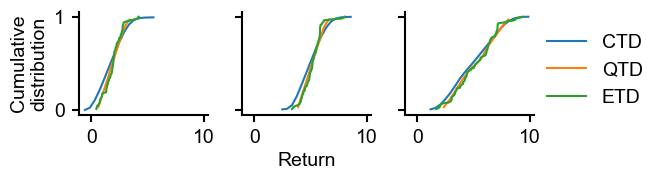

In [8]:
fig, axs = plt.subplots(1, n_cues, figsize=(7, 2), sharex=True, sharey=True)
epsilon = 1e-3

for i, cue_state in enumerate(cue_states):
    
    ax = axs[i]

    # plot CDF from CTD
    p = softmax(phi[np.newaxis, cue_state] @ ws).flatten()
    to_plot = p > epsilon
    ax.plot(theta[to_plot], np.cumsum(p)[to_plot], label='CTD')
    
    # plot CDF from QTD
    ax.plot((phi[np.newaxis, cue_state] @ qs).flatten(), taus, label='QTD')
    
    # plot expectile function
#     ax = axs[3, i]
#     ax.plot(xs[cue_state, :], taus, label='ETD')

    # plot ECDF derived from expectile function
    samples, loss = run_decoding((phi[np.newaxis, cue_state] @ xs).flatten(), taus, minv=0., maxv=max_pred)
    xcdf = ECDF(samples)
    ax.plot(xcdf.x, xcdf.y, label='ETD')

plt.legend(loc=(1.04, 0))
axs[0].set_ylabel('Cumulative\ndistribution')
axs[1].set_xlabel('Return')
plt.tight_layout()
hide_spines()

# Get predictions from the microstimulus model for each cue x outcome combination

In [9]:
n_events = 2
n_models = 3
event_names = ['Cue', 'Outcome']
tt_names = ['Nothing', 'Fixed', 'Variable 2', 'Variable 6', 'Unexpected']
tt_outcomes = [0, 4, 2, 6, 4]
cscale = 1


# fig, axs = plt.subplots(n_tt, n_events, figsize=(6, 4))

pred_dict = {'tt': [],
             'event': [],
             'combo': [],
             'combo_name': [],
             'model': [],
             'i_pred': [],
             'response': []}

for i_tt in range(n_combos):
            
    cue = i_tt if i_tt < n_cues else i_tt - 1
    outcome = tt_outcomes[i_tt]
    
    if cue < n_cues:
        cue_state = cue_states[cue]
#         preoutcome_state = last_cue_states[cue]
    else:
        cue_state = None
#         preoutcome_state = iti_state
    
#     outcome = 1 if i_tt < 2 else 0
#     outcome_state = [norew_start_state, rew_start_state][outcome]
#     last_outcome_state = [norew_start_state + rew_dur, rew_start_state + rew_dur][outcome] - 1
    
#     for i_event, i_state in enumerate([n_states - 1, 0, last_cue_state, last_outcome_state]):
    
    for i_event, i_state in enumerate([cue_state, n_cue_states]):
        
        if i_state is not None:

            pred_dict['response'].extend((np.mean(last_da[:, i_tt, i_state],
                                                  axis=-1) * np.array([1, 1, cscale]).reshape(-1, 1) * 100).flatten())
            pred_dict['i_pred'].extend(np.tile(np.arange(n_preds), n_models))
            pred_dict['model'].extend(np.repeat(['QTD', 'ETD', 'CTD'], n_preds))
            pred_dict['event'].extend(np.repeat(event_names[i_event], n_preds * n_models))
            pred_dict['combo'].extend(np.repeat(i_event + i_tt * n_combos, n_preds * n_models))
            pred_dict['combo_name'].extend(np.repeat(f'{tt_names[i_tt]} {event_names[i_event]}', n_preds * n_models))
            pred_dict['tt'].extend(np.repeat(tt_names[i_tt], n_preds * n_models))

pred_df = pd.DataFrame(pred_dict)

Text(0.5, 1.0, 'ETD')

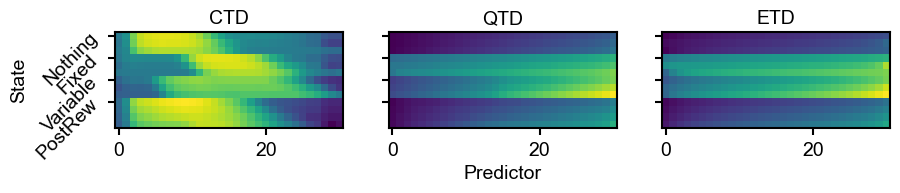

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10, 7), sharey=True, sharex=True)
ax = axs[0]
ax.imshow(phi @ ws)
ax.set_title('CTD')
ax.set_ylabel('State')
# ax.set_yticks(np.concatenate((cue_states, [rew_start_state, rew_start_state + rew_dur, norew_start_state,
#                                            norew_start_state + rew_dur, iti_start_state])),
#               ['Cue 1', 'Cue 2', 'Cue 3', 'Reward Start', 'Reward End', 'No Reward Start', 'No Reward End', 'Light Off (ITI)'], rotation=45)
ax.set_yticks(start_states, [*cue_names, 'PostRew'], rotation=45)
ax = axs[1]
ax.imshow(phi @ qs)
ax.set_xlabel('Predictor')
ax.set_title('QTD')

ax = axs[2]
ax.imshow(phi @ xs)
ax.set_title('ETD')

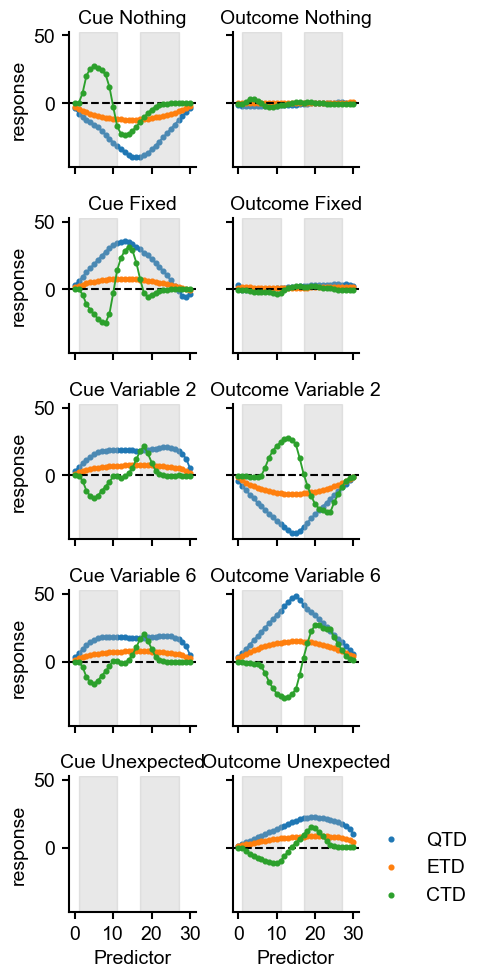

In [11]:
n_grp = 10
g = sns.FacetGrid(data=pred_df, col='event', row='tt', height=2)
g.map_dataframe(sns.pointplot, x='i_pred', order=np.arange(n_preds), y='response', hue='model',
                palette=sns.color_palette(), scale=.5).set_titles('{col_name} {row_name}')
g.map(plt.axhline, y=0, color='k', ls='--')
g.set(xticks=np.arange(0, n_preds, 10), xticklabels=np.arange(0, n_preds, 10))
plt.legend(loc=(1.04, 0))

for ax in g.axes.flat: 
    ax.axvspan(1, 1+n_grp, alpha=.3, color=[.7,.7,.7])
    ax.axvspan(17, 17+n_grp, alpha=.3, color=[.7,.7,.7])
    ax.set_xlabel('Predictor')

In [12]:
pess_inds = np.arange(1, 1 + n_grp)
opt_inds = np.arange(17, 17 + n_grp)
pred_df['optopess'] = 'Neutral'
pred_df.loc[np.isin(pred_df['i_pred'], pess_inds), 'optopess'] = 'Pessimistic'
pred_df.loc[np.isin(pred_df['i_pred'], opt_inds), 'optopess'] = 'Optimistic'

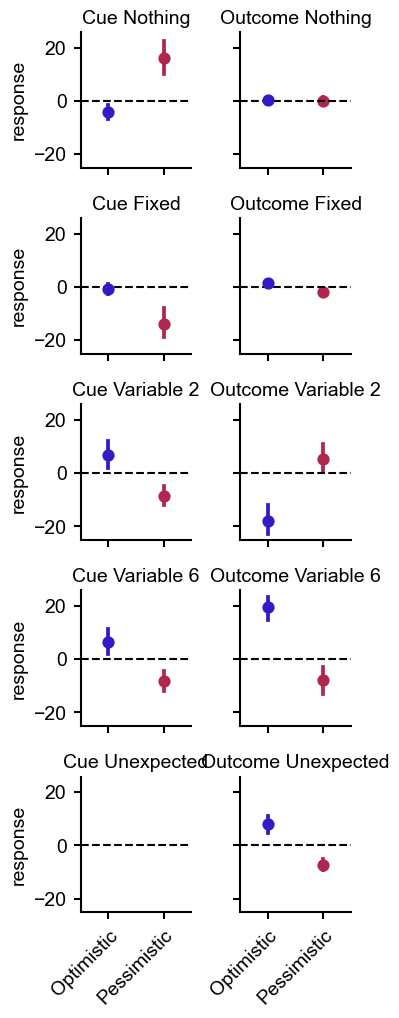

In [13]:
# plot average response of optimistic (type 1) and pessimistic (type 2) neurons to different events
i_pred_palette = list(asym_cmap(taus))
g = sns.FacetGrid(data=pred_df[pred_df['model'] == 'CTD'], col='event', row='tt', height=2)
g.map_dataframe(sns.pointplot, x='optopess', order=['Optimistic', 'Pessimistic'], y='response',
                hue='optopess', palette=i_pred_palette[6::n_preds // 2]).set_titles('{col_name} {row_name}')
for ax in g.axes.flat:
    ax.axhline(0, color='k', ls='--')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax.set_xlabel('')

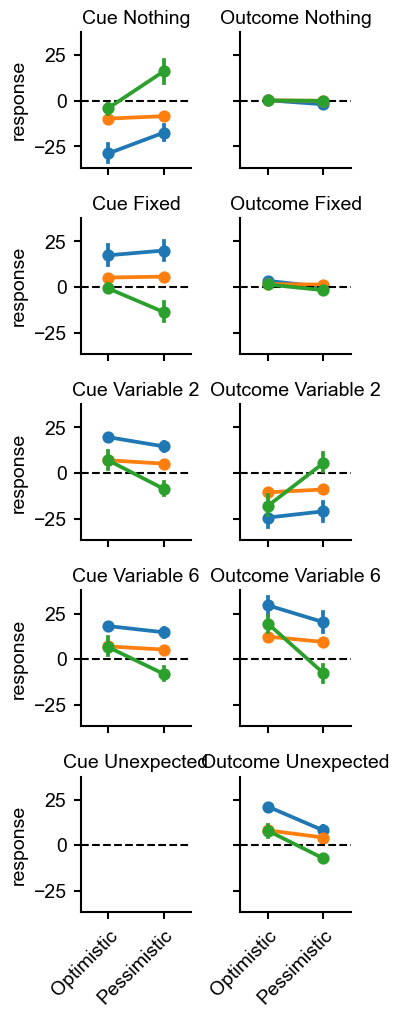

In [14]:
# plot average response of optimistic (type 1) and pessimistic (type 2) neurons to different events
i_pred_palette = list(asym_cmap(taus))
g = sns.FacetGrid(data=pred_df, col='event', row='tt', height=2)
g.map_dataframe(sns.pointplot, x='optopess', order=['Optimistic', 'Pessimistic'], y='response',
                hue='model', palette=sns.color_palette()).set_titles('{col_name} {row_name}')
for ax in g.axes.flat:
    ax.axhline(0, color='k', ls='--')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax.set_xlabel('')

In [160]:
tt_df = pred_df.pivot(index=['tt', 'model', 'i_pred', 'optopess'], columns='event', values='response').reset_index()

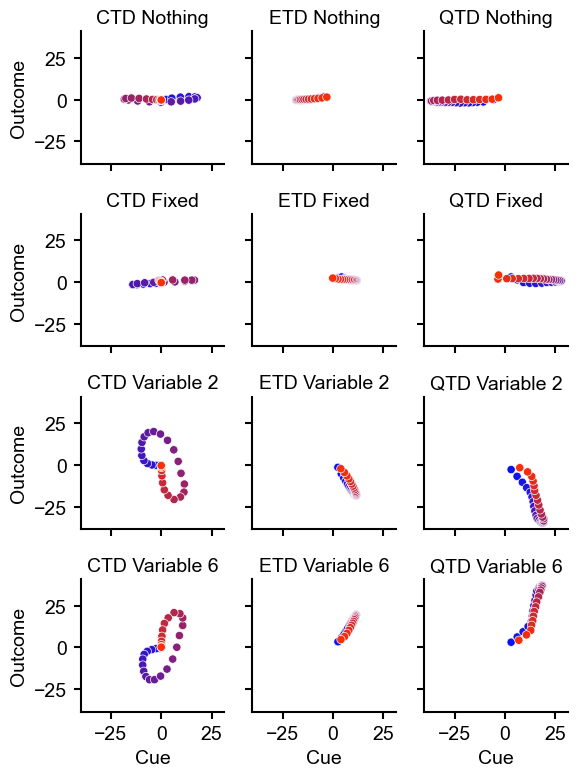

In [171]:
for (x, y) in [('Cue', 'Outcome')]: 
    g = sns.FacetGrid(data=tt_df, col='model', row='tt', row_order=tt_names[:-1], height=2)
    g.map_dataframe(sns.scatterplot, x=x, y=y, hue='i_pred', palette=list(i_pred_palette)).set_titles('{col_name} {row_name}')

In [163]:
corr_df = pred_df.pivot(index=['model', 'i_pred'], columns=['event', 'tt'], values='response').reset_index()
corr_df.columns = ['_'.join(col) for col in corr_df.columns.values]

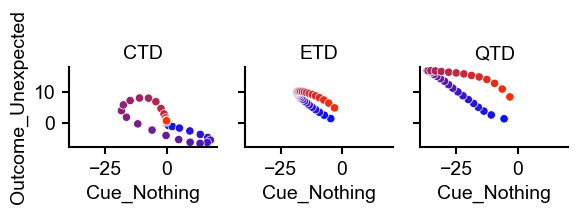

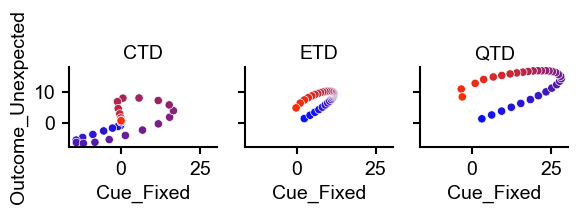

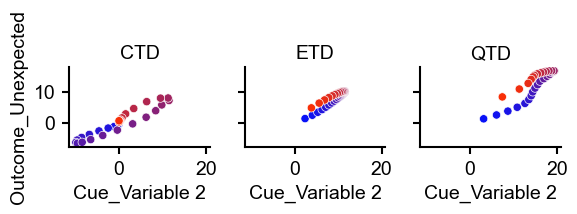

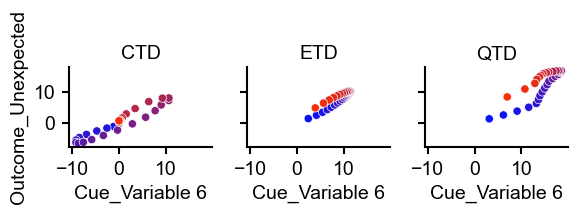

In [170]:
for tt_name in tt_names[:-1]:    
    g = sns.FacetGrid(data=corr_df, col='model_', height=2)
    g.map_dataframe(sns.scatterplot, x='Cue_{}'.format(tt_name), y='Outcome_Unexpected', hue='i_pred_', 
                    palette=list(i_pred_palette)).set_titles('{col_name}')

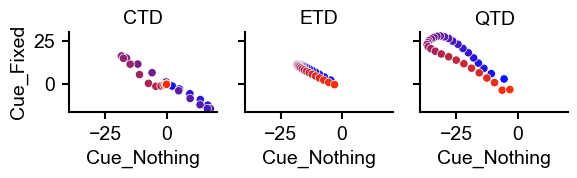

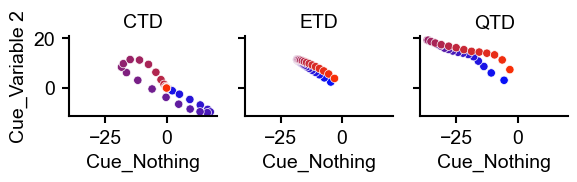

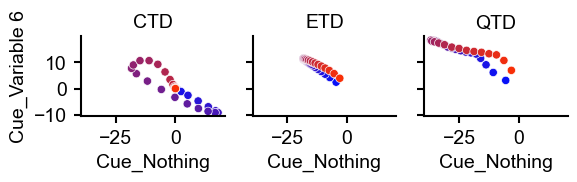

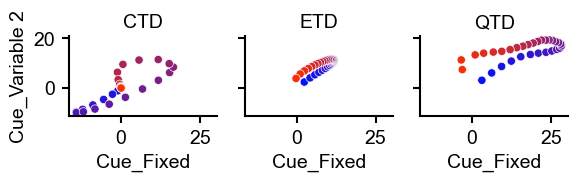

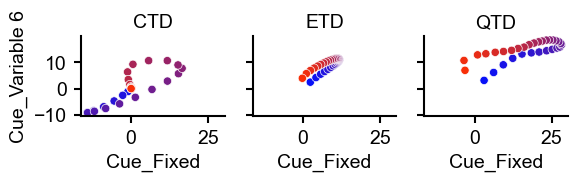

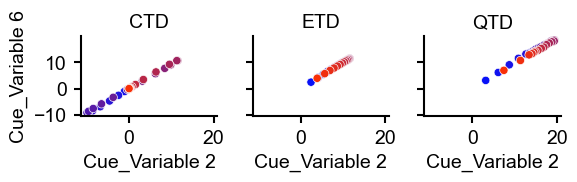

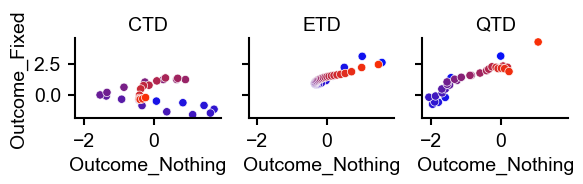

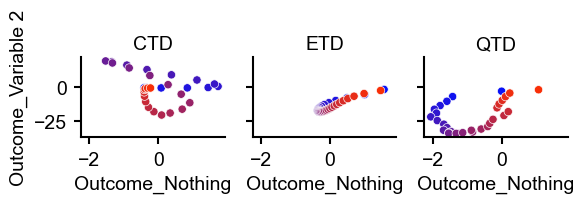

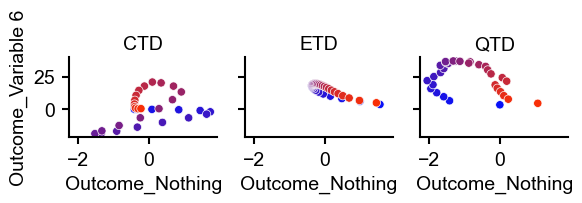

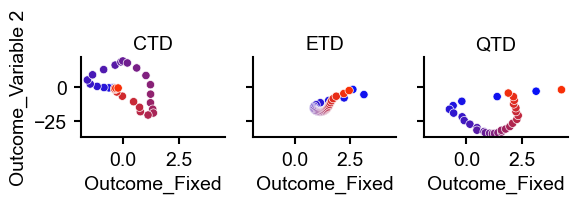

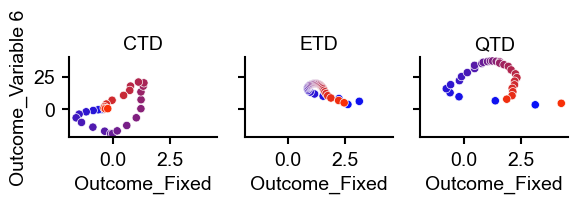

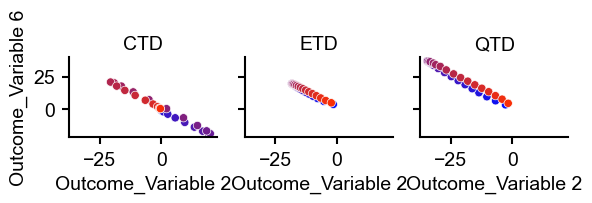

In [166]:
pairs = list(itertools.combinations(['Nothing', 'Fixed', 'Variable 2', 'Variable 6'], 2))
for event in event_names:
    for tt in pairs:
        x = '_'.join([event, tt[0]])
        y = '_'.join([event, tt[1]])
        g = sns.FacetGrid(data=corr_df, col='model_', height=2)
        g.map_dataframe(sns.scatterplot, x=x, y=y, hue='i_pred_', palette=list(i_pred_palette)).set_titles('{col_name}')